# Irish data set Analyzing

## 1. Read dataset

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as sm
import seaborn as sns
sns.set(style="ticks", palette="pastel")
plt.style.use('seaborn-deep')

random.seed(1509)

In [30]:
data = pd.read_csv("iris_data.csv")

In [31]:
data.head(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [32]:
classes = list(set(list(data['Species'])))
classes = sorted(classes)
ft_names = list(data.columns)[:-1]
n_ft = len(ft_names)

In [33]:
data_classes = {}
for cl in classes:
    data_classes[cl] = data[data['Species']==cl]

In [34]:
info = 'There are {} classes in dataset:'.format(len(classes))
for cl in classes:
    info += ' {},'.format(cl)
info = info[:-1] + '.\n'
info += 'Number of samples in each class:\n'
for cl in classes:
    info += '{}: {} samples\n'.format(cl, data_classes[cl].shape[0])
info += 'There are {} features:'.format(n_ft)
for idx in range(n_ft):
    info += ' {},'.format(ft_names[idx])
info = info[:-1]
print(info)

There are 3 classes in dataset: setosa, versicolor, virginica.
Number of samples in each class:
setosa: 50 samples
versicolor: 50 samples
virginica: 50 samples
There are 4 features: Sepal.Length, Sepal.Width, Petal.Length, Petal.Width


## 2. Check missing value

In [35]:
n_missing_classes = {}
for cl in classes:
    missing = list(data_classes[cl].isnull().sum())[:-1] # remove species column
    n_missing_classes[cl] = [0 for x in range(n_ft)]
    for idx, val in enumerate(missing):
        n_missing_classes[cl][idx] = val

In [36]:
info = ''
for cl in classes:
    info += '{} has {} missing'.format(cl, sum(n_missing_classes[cl]))
    if sum(n_missing_classes[cl]) > 0:
        info += ':'
        ft_miss = [x for x in range(n_ft) if n_missing_classes[cl][x] > 0]
        for index in ft_miss:
            info += ' {} in {},'.format(n_missing_classes[cl][index], ft_names[index])
        info = info[:-1]
    info += '\n'
print(info)

setosa has 1 missing: 1 in Sepal.Length
versicolor has 2 missing: 1 in Sepal.Width, 1 in Petal.Length
virginica has 0 missing



## 3. Filling missing value

In [38]:
cl = classes[0]
data_cl = data_classes[cl]
ft_missing = [x for x in range(n_ft) if n_missing_classes[cl][x] > 0]
print(ft_missing)

[0]


Here the missing value is in column 0, which is ```Sepal.Length```. We will perform regression to predict missing value in this (response) column.

In [39]:
corr=data_cl.corr()
corr

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.000000,0.736298,0.197411,0.234879
Sepal.Width,0.736298,1.000000,0.177700,0.232752
Petal.Length,0.197411,0.177700,1.000000,0.331630
Petal.Width,0.234879,0.232752,0.331630,1.000000


As we can see, the ```Sepal.Length``` is highly correlated with ```Sepal.Width```, we can do regression as ```Sepal.Length = a + b * Sepal.Width```. But we also perform multiple linear regression by using all features to make the comparison. We expect that the normal regression will be better than multiple model since 2 other features are low correlated with the response column.

In [40]:
missing_index = list(data_cl.loc[data_cl.isnull().any(1)].index)

In [41]:
ft_value = {}
for idx, ft in enumerate(ft_names):
    ft_value[ft] = list(data_cl.iloc[:,idx])
    ft_value[ft] = [j for i, j in enumerate(ft_value[ft]) if i not in missing_index]

In [42]:
index_subset = [x for x in range(len(ft_value[ft_names[0]]))]
random.shuffle(index_subset)

### a. Split dataset

In [43]:
ft_train = {}
ft_test = {}
for ft in ft_names:
    ft_train[ft] = [ft_value[ft][x] for x in index_subset[0:40]]
    ft_test[ft] = [ft_value[ft][x] for x in index_subset[40:]]

In [44]:
data_train = pd.DataFrame(ft_train)
data_train.columns = ["Y", "X", "W", "Z"]

### b. MLR
We perform Multiple Linear Regression model by using all features

In [45]:
formula_str="Y ~ X + W + Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     14.94
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           1.77e-06
Time:                        00:52:31   Log-Likelihood:                 1.7564
No. Observations:                  40   AIC:                             4.487
Df Residuals:                      36   BIC:                             11.24
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6529      0.449      5.910      0.0

In [46]:
y_pred = list(result.predict({"X": ft_value[ft_names[1]], 
                              "W": ft_value[ft_names[2]], 
                              "Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[0]],y_pred)]

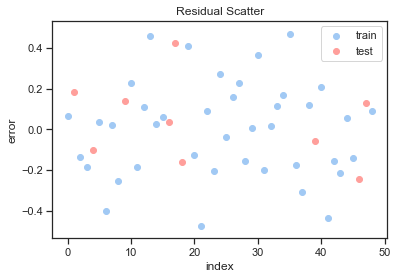

In [47]:
plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

In [48]:
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))

Mean Residual: 0.007269615599574968
Std Residual: 0.22559712363918913


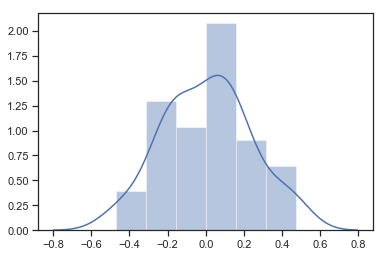

In [49]:
sns.distplot(residual_np)

### c. LR
We perform Linear Regression model by using only highest correlated feature to compare with Multiple Linear Regression model

In [50]:
formula_str="Y ~ X"
result=sm.ols(formula=formula_str,data=data_train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     45.46
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           5.50e-08
Time:                        00:52:36   Log-Likelihood:                 1.3158
No. Observations:                  40   AIC:                             1.368
Df Residuals:                      38   BIC:                             4.746
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7652      0.335      8.251      0.0

In [51]:
y_pred = list(result.predict({"X": ft_value[ft_names[1]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[0]],y_pred)]

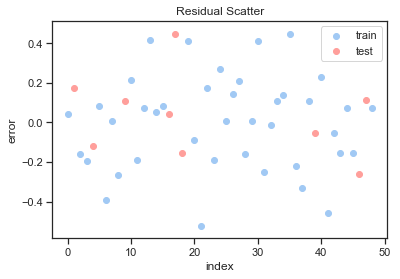

In [52]:
plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

In [53]:
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))

Mean Residual: 0.006000479878429213
Std Residual: 0.22836456145805897


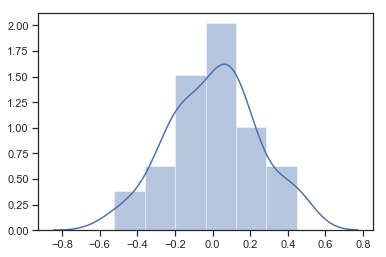

In [54]:
sns.distplot(residual_np)

### d. Predict missing value
Here we will choose the better model to predict the missing value. As we can see, the normal model have better AIC and BIC value (lower is better) and the error scatter plot also show that the error seems to be independent and follows normal distributed with mean of 0

In [55]:
y_pred = result.predict({"X": data_cl.iloc[missing_index[0],1]})
print(y_pred)
data_classes[classes[0]].iloc[missing_index[0],0] = list(y_pred)[0]

0    4.728576
dtype: float64


/Users/duynguyen/anaconda3/envs/dadm/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### e. Do the same with the other class

In [57]:
cl = classes[1]
data_classes[cl].index = [x for x in range(len(data_classes[cl]))]
data_cl = data_classes[cl]
ft_missing = [x for x in range(n_ft) if n_missing_classes[cl][x] > 0]
print(ft_missing)
corr=data_cl.corr()
corr

[1, 2]


,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.000000,0.479991,0.754904,0.546461
Sepal.Width,0.479991,1.000000,0.523657,0.638250
Petal.Length,0.754904,0.523657,1.000000,0.785790
Petal.Width,0.546461,0.638250,0.785790,1.000000


Since there are missing in 2 columns which are ```Sepal.Width```, and ```Petal.Length```. We will perform regression each of them separately.

In [58]:
missing_index = list(data_cl.loc[data_cl.isnull().any(1)].index)
ft_value = {}
for idx, ft in enumerate(ft_names):
    ft_value[ft] = list(data_cl.iloc[:,idx])
    ft_value[ft] = [j for i, j in enumerate(ft_value[ft]) if i not in missing_index]

#### 1. Sepal.Width

In [59]:
index_subset = [x for x in range(len(ft_value[ft_names[1]]))]
random.shuffle(index_subset)
ft_train = {}
ft_test = {}
for ft in ft_names:
    ft_train[ft] = [ft_value[ft][x] for x in index_subset[0:40]]
    ft_test[ft] = [ft_value[ft][x] for x in index_subset[40:]]

In [60]:
data_train = pd.DataFrame(ft_train)
data_train.columns = ["X", "Y", "W", "Z"]

In [61]:
formula_str="Y ~ X + W + Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"X": ft_value[ft_names[0]], 
                              "W": ft_value[ft_names[2]], 
                              "Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[1]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

Mean Residual: -0.021405506402627016
Std Residual: 0.2210592080980153
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     9.314
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           0.000108
Time:                        00:54:30   Log-Likelihood:                 4.8273
No. Observations:                  40   AIC:                            -1.655
Df Residuals:                      36   BIC:                             5.101
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

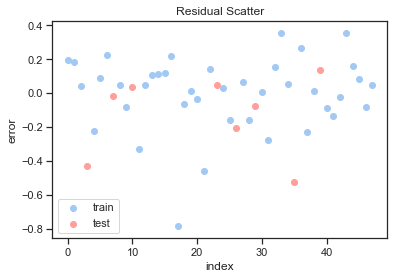

In [62]:
plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

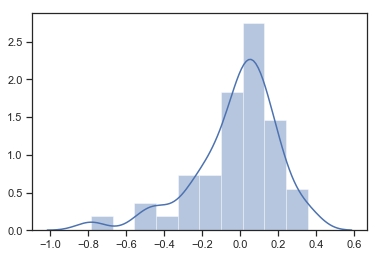

In [63]:
sns.distplot(residual_np)

Mean Residual: -0.020419776711631404
Std Residual: 0.2222240858416721
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     13.85
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           3.24e-05
Time:                        00:54:55   Log-Likelihood:                 4.5132
No. Observations:                  40   AIC:                            -3.026
Df Residuals:                      37   BIC:                             2.040
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

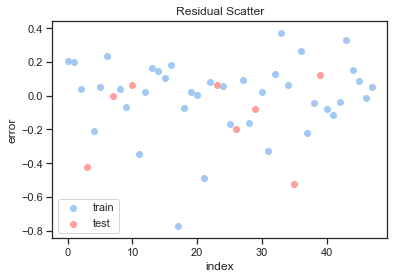

In [68]:
formula_str="Y ~ X + Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"X": ft_value[ft_names[0]],  
                              "Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[1]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

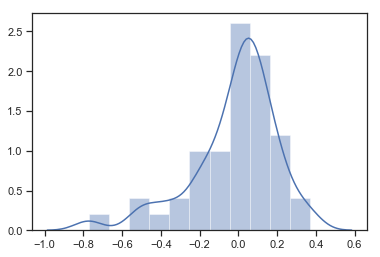

In [69]:
sns.distplot(residual_np)

Mean Residual: -0.020971446586201908
Std Residual: 0.22818357282011184
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     24.32
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           1.65e-05
Time:                        00:54:32   Log-Likelihood:                 3.2311
No. Observations:                  40   AIC:                            -2.462
Df Residuals:                      38   BIC:                            0.9156
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

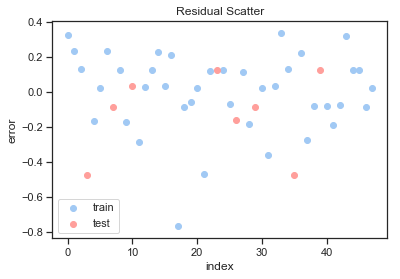

In [66]:
formula_str="Y ~ Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[1]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

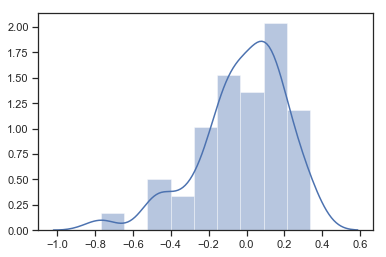

In [67]:
sns.distplot(residual_np)

As we can see the result from 3 models, the first model (using all features) is worse than the 2 latter (based on AIC, and BIC). Regarding the latter 2 models, the AIC and BIC show that there is no impact of number of features. However, we can use the 2nd model ```Sepal.Width ~ Sepal.Length + Petal.Width``` as it has smaller mean residual error.

In [70]:
y_pred = result.predict({"X": data_cl.iloc[missing_index[0],0],
                         "Z": data_cl.iloc[missing_index[0],3]})
print(y_pred)
data_classes[classes[1]].iloc[missing_index[0],1] = list(y_pred)[0]

0    2.41719
dtype: float64


#### 2. Petal.Length

In [71]:
index_subset = [x for x in range(len(ft_value[ft_names[2]]))]
random.shuffle(index_subset)
ft_train = {}
ft_test = {}
for ft in ft_names:
    ft_train[ft] = [ft_value[ft][x] for x in index_subset[0:40]]
    ft_test[ft] = [ft_value[ft][x] for x in index_subset[40:]]
    
data_train = pd.DataFrame(ft_train)
data_train.columns = ["X", "W", "Y", "Z"]

Mean Residual: -0.004871669553123792
Std Residual: 0.22827940194223786
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     33.15
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           1.85e-10
Time:                        00:55:21   Log-Likelihood:               0.074093
No. Observations:                  40   AIC:                             7.852
Df Residuals:                      36   BIC:                             14.61
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

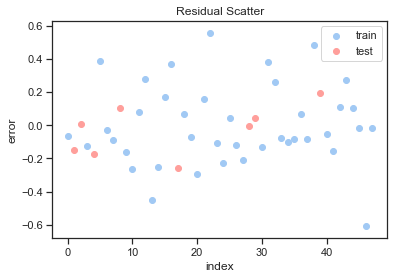

In [72]:
formula_str="Y ~ X + W + Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"X": ft_value[ft_names[0]],
                              "W": ft_value[ft_names[1]],
                              "Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[2]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

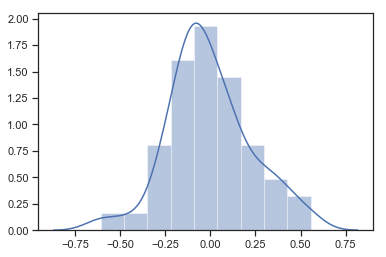

In [73]:
sns.distplot(residual_np)

Mean Residual: -0.001630756885327674
Std Residual: 0.22842715689898374
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     49.16
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           3.82e-11
Time:                        00:55:35   Log-Likelihood:               -0.49294
No. Observations:                  40   AIC:                             6.986
Df Residuals:                      37   BIC:                             12.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

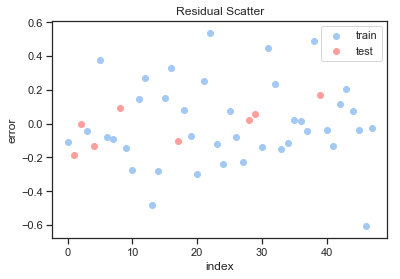

In [78]:
formula_str="Y ~ X + Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"X": ft_value[ft_names[0]],
                              "Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[2]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

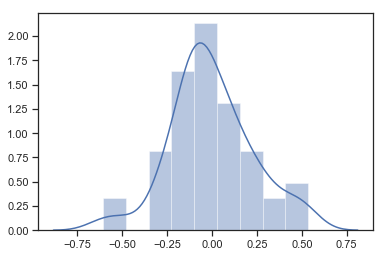

In [79]:
sns.distplot(residual_np)

Mean Residual: 0.0182107023411336
Std Residual: 0.29201199475063183
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     50.36
Date:                Thu, 06 Feb 2020   Prob (F-statistic):           1.82e-08
Time:                        00:55:23   Log-Likelihood:                -9.5506
No. Observations:                  40   AIC:                             23.10
Df Residuals:                      38   BIC:                             26.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

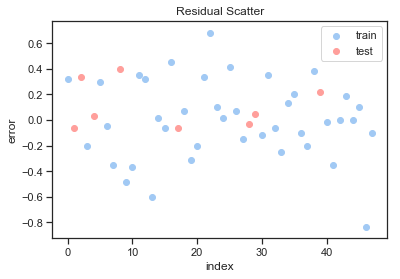

In [76]:
formula_str="Y ~ Z"
result=sm.ols(formula=formula_str,data=data_train).fit()
y_pred = list(result.predict({"Z": ft_value[ft_names[3]]}))
residual = [i - j for i,j in zip(ft_value[ft_names[2]],y_pred)]
residual_np = np.array(residual)
mean_resid = np.mean(residual_np)
std_resid = np.std(residual_np)
print("Mean Residual: {}\nStd Residual: {}".format(mean_resid, std_resid))
print(result.summary())

plt.scatter([x for x in index_subset[0:40]], [residual[x] for x in index_subset[0:40]], color='b', label = 'train')
plt.scatter([x for x in index_subset[40:]], [residual[x] for x in index_subset[40:]], color='r', label = 'test')
plt.title('Residual Scatter')
plt.xlabel('index')
plt.ylabel('error')
plt.legend()
plt.show()

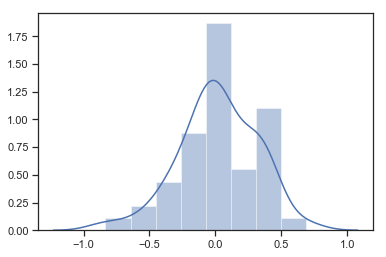

In [77]:
sns.distplot(residual_np)

Note that in the 1st model (using all features), the P value for predictor X, Z (```Sepal.Length```, ```Petal.Width```) are low. This is consistent with the correlation matrix. In the 2nd model, the P value also show that these 2 features are important to the model. However, we also want to try what would happen if only 1 highest correlated feature was used. The AIC, BIC show that this is the worst model, belong with the mean error.
So we will choose the model ```Petal.Length ~ Sepal.Length + Petal.Width```.

In [80]:
y_pred = result.predict({"X": data_cl.iloc[missing_index[1],0],
                         "Z": data_cl.iloc[missing_index[1],3]})
print(y_pred)
data_classes[classes[1]].iloc[missing_index[1],2] = list(y_pred)[0]

0    4.51766
dtype: float64


In [81]:
cl = classes[2]
data_classes[cl].index = [x for x in range(len(data_classes[cl]))]

## 4. Plot Boxplot
Here we will split the data into 2 subset: training and testing to ensure the generality of the prediction model that we want to build. First we will plot the training data distribution first, then have insight of it and finally create the plan to create the prediction model

In [2]:
#frames = [data_classes[x] for x in classes]
#data_filled = pd.concat(frames)
#data_filled.index = [x for x in range(len(data_filled))]
#data_filled.to_csv('iris_dataset_filled.csv', index = None, header=True)
data_filled = pd.read_csv("iris_dataset_filled.csv")

classes = list(set(list(data_filled['Species'])))
classes = sorted(classes)
ft_names = list(data_filled.columns)[:-1]
n_ft = len(ft_names)
data_classes_all = {}
data_classes_train = {}
data_classes_test = {}

for cl in classes:
    data_classes_all[cl] = data_filled[data_filled['Species']==cl]
    data_classes_all[cl] = data_classes_all[cl].sample(frac=1)
    data_classes_train[cl] = data_classes_all[cl].iloc[:40]
    data_classes_test[cl] = data_classes_all[cl].iloc[40:]
    
data_train = [data_classes_train[x] for x in classes]
data_train = pd.concat(data_train)
data_test = [data_classes_test[x] for x in classes]
data_test = pd.concat(data_test)

### a. Sepal.Length

Text(0.5,0,'Sepal.Length')

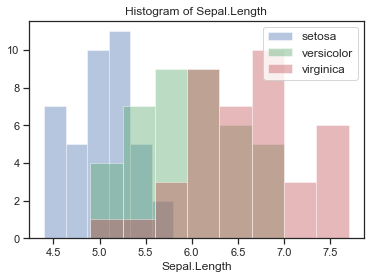

In [4]:
sns.distplot(data_classes_train[classes[0]].iloc[:,0], kde=False, label=classes[0])
sns.distplot(data_classes_train[classes[1]].iloc[:,0], kde=False, label=classes[1])
sns.distplot(data_classes_train[classes[2]].iloc[:,0], kde=False, label=classes[2])

plt.title('Histogram of {}'.format(ft_names[0]))
plt.legend(prop={'size': 12})
plt.xlabel(ft_names[0])

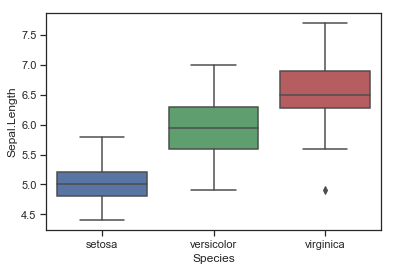

In [5]:
sns.boxplot(x="Species", y="Sepal.Length",
            data=data_train)

### b. Sepal.Width

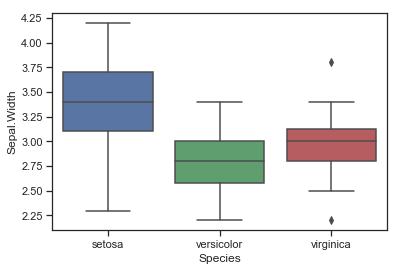

In [6]:
sns.boxplot(x="Species", y="Sepal.Width",
            data=data_train)

### c. Petal.Length

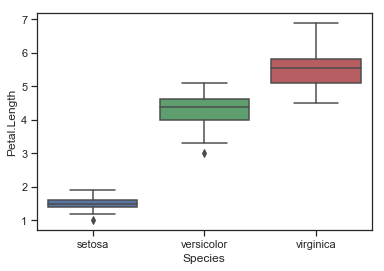

In [7]:
sns.boxplot(x="Species", y="Petal.Length", data=data_train)

### d. Petal.Width

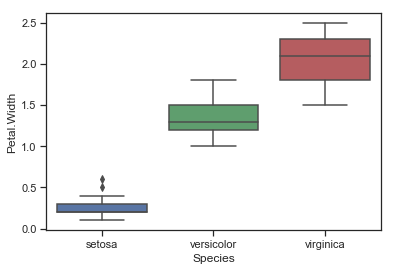

In [8]:
sns.boxplot(x="Species", y="Petal.Width", data=data_train)

**Initial Conclusion**

- We can easily classify ```setosa``` based on ```Petal.Length < 2.5``` or ```Petal.Width < 0.75``` since there is a huge gap between it with other classes
- For ```versicolor``` and ```virginica```, we now can perform logistic regression as binary classification. It seems that ```Petal.Width``` will have big impact as we can see the boxplot

## 5. Logistic Regression

In [104]:
data_train_2 = [data_classes_train[x] for x in classes[1:]]
data_train_2 = pd.concat(data_train_2)
data_train_2_sf = data_train_2.sample(frac=1)

data_test_2 = [data_classes_test[x] for x in classes[1:]]
data_test_2 = pd.concat(data_test_2)

In [105]:
data_train_2_binary = data_train_2_sf.replace(to_replace =["versicolor", "virginica"],  
                     value = [0, 1])
data_test_2_binary = data_test_2.replace(to_replace =["versicolor", "virginica"],  
                     value = [0, 1])

data_train_2_binary.columns = ['X1', 'X2', 'X3', 'X4', 'Y']
data_test_2_binary.columns = ['X1', 'X2', 'X3', 'X4', 'Y']

formula_str="Y ~ X1 + X2 + X3 + X4"
result=sm.logit(formula=formula_str,data=data_train_2_binary).fit()

Optimization terminated successfully.
         Current function value: 0.073201
         Iterations 11


In [107]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       75
Method:                           MLE   Df Model:                            4
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                  0.8944
Time:                        23:50:02   Log-Likelihood:                -5.8561
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                 1.462e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -38.3844     26.489     -1.449      0.147     -90.302      13.533
X1            -2.1636      2.514     -0.861      0.389      -7.091       2.764
X2            -6.9026      4.751     -1.453      0.1

As we can see, the p value of coefficient of ```X3, X4``` (which are ```Petal.Length, Petal.Width```) show that these 2 features contribute more to the model. Although they are not really significant. We will try to run only based on 2 features

In [108]:
formula_str="Y ~ X3 + X4"
result_3=sm.logit(formula=formula_str,data=data_train_2_binary).fit()
print(result_3.summary())

Optimization terminated successfully.
         Current function value: 0.123931
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                   80
Model:                          Logit   Df Residuals:                       77
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                  0.8212
Time:                        23:50:03   Log-Likelihood:                -9.9145
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                 1.673e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -41.6497     13.510     -3.083      0.002     -68.130     -15.170
X3             5.2047      2

In [109]:
def logPredict(modelParams, X):  
    probabilities = modelParams.predict(X)
    return [1 if x >= 0.5 else 0 for x in probabilities]

prediction = logPredict(result, data_train_2_binary.iloc[:,:-1])
prediction_2 = logPredict(result_2, data_train_2_binary.iloc[:,:-1])
accuracy = np.mean(prediction == data_train_2_binary.iloc[:,-1])
accuracy_2 = np.mean(prediction_2 == data_train_2_binary.iloc[:,-1])
print ('accuracy using all 4 features = {0}%'.format(accuracy*100))
print ('accuracy using only 2 features = {0}%'.format(accuracy_2*100))

accuracy using all 4 features = 97.5%
accuracy using only 2 features = 92.5%


In [110]:
prediction = logPredict(result, data_test_2_binary.iloc[:,:-1])
prediction_2 = logPredict(result_2, data_test_2_binary.iloc[:,:-1])
accuracy = np.mean(prediction == data_test_2_binary.iloc[:,-1])
accuracy_2 = np.mean(prediction_2 == data_test_2_binary.iloc[:,-1])
print ('[Test] accuracy using all 4 features = {0}%'.format(accuracy*100))
print ('[Test] accuracy using only 2 features = {0}%'.format(accuracy_2*100))

[Test] accuracy using all 4 features = 100.0%
[Test] accuracy using only 2 features = 100.0%


We can see that both model can predict correctly entire test dataset although training accuracy of 2-feature model is lower than the one using 4 features. Therefore we will choose the model using all 4 features to create our final prediction model

## 6. Final  Prediction Model
Here we will combile rule-based and logistic regression to have the final model

In [111]:
class our_model(object):
    def __init__(self, logistic_model):
        super().__init__()
        self.log_model = logistic_model
    def predict(self, feature):
        result = ['a' for _ in range(feature.shape[0])]
        for idx in range(feature.shape[0]):
            if feature.iloc[idx, 2] < 2.5:
                result[idx] = 'setosa'
            else:
                input_ft = feature.iloc[idx,:]
                pred = logPredict(self.log_model, input_ft)[0]
                if pred == 0:
                    result[idx] = 'versicolor'
                else:
                    result[idx] = 'virginica'
        result = np.asarray(result)
        return result
    def score(self, feature, lbl):
        result = self.predict(feature)
        total_samples = len(result)
        total_correct = np.sum(result == lbl)
        return total_correct/total_samples
    

In [112]:
basic_model = our_model(result)

In [113]:
data_filled.columns = ['X1', 'X2', 'X3', 'X4', 'Y']
data_train.columns = ['X1', 'X2', 'X3', 'X4', 'Y']
data_test.columns = ['X1', 'X2', 'X3', 'X4', 'Y']

In [114]:
acc_overall = basic_model.score(data_filled.iloc[:,:-1], data_filled.iloc[:, -1].to_numpy())
acc_train = basic_model.score(data_train.iloc[:,:-1], data_train.iloc[:, -1].to_numpy())
acc_test = basic_model.score(data_test.iloc[:,:-1], data_test.iloc[:, -1].to_numpy())
acc_overall, acc_train, acc_test

(0.9866666666666667, 0.9833333333333333, 1.0)

### a. Confusion Matrix
Here the left column is the label and the top row is for prediction

In [117]:
pred = basic_model.predict(data_filled.iloc[:,:-1])
lbl = data_filled.iloc[:, -1].to_numpy()

In [118]:
cm = metrics.confusion_matrix(lbl, pred)

In [119]:
print(cm)

[[50  0  0]
 [ 0 49  1]
 [ 0  1 49]]


### b. ROC - AUC
Here we will plot the ROC of logistic regression only (for versicolor and virginica classes)

In [122]:
data_lgmodel = [data_classes_all[x] for x in classes[1:]]
data_lgmodel = pd.concat(data_lgmodel)
data_lgmodel.columns = ['X1', 'X2', 'X3', 'X4', 'Y']
data_lgmodel = data_lgmodel.replace(to_replace =["versicolor", "virginica"],  
                                    value = [0, 1])

pred_lgmodel = result.predict(data_lgmodel.iloc[:,:-1]).to_numpy()
pred_nomodel = np.asarray([0 for idx in range(len(data_lgmodel))])
lbl = data_lgmodel.iloc[:,-1].to_numpy()
nomodel_auc = roc_auc_score(lbl, pred_nomodel)
lgmodel_auc = roc_auc_score(lbl, pred_lgmodel)

print('No Model (Guess all with 1 class): ROC AUC=%.3f' % (nomodel_auc))
print('Logistic: ROC AUC=%.3f' % (lgmodel_auc))

No Model (Guess all with 1 class): ROC AUC=0.500
Logistic: ROC AUC=0.997


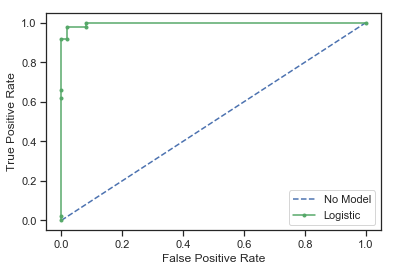

In [123]:

no_fpr, no_tpr, _ = roc_curve(lbl, pred_nomodel)
lg_fpr, lg_tpr, _ = roc_curve(lbl, pred_lgmodel)

pyplot.plot(no_fpr, no_tpr, linestyle='--', label='No Model')
pyplot.plot(lg_fpr, lg_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

**Note**

So as we can see, the simple combination of rule-based and binary logistic regression model can get the overall accuracy about 98.7% (not bad at all). And the weight of the logistic regression also prove that ```Petal.Length``` and ```Petal.Width``` have big impact to it. But there are still places to have deeper insights into it, e.g. using multinomial logistic regression or random forest.

## References
[1] https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python

[2] https://github.com/Mashimo/datascience/blob/master/01-Regression/LogisticRegressionSM.ipynb